In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout,Conv2D,BatchNormalization,LeakyReLU,Concatenate,UpSampling2D,MaxPool2D,Add
from keras import backend as K
import math
import numpy as np

2025-07-16 20:45:39.788691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 20:45:39.915996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752687939.969309   60385 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752687939.984526   60385 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752687940.077567   60385 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
NUM_CLASSES = 60
NUM_ANCHORS = 3
constant_anchors = {
    #"52":[[10,13], [16,30], [33,23]],
    26:[[4.75817,3.8235295],[9.894817,7.009804],[17.561403,14.1470585]],
    13:[[35.25196,29.227486],[72.22222,58.950325],[166.44061,143.75555]],
}

ANCHORS = np.array([[4.75817,3.8235295],[9.894817,7.009804],[17.561403,14.1470585],[35.25196,29.227486],[72.22222,58.950325],[166.44061,143.75555]])

ANCHOR_INDECES = {
    26:[0,1,2],
    13:[3,4,5],
}

In [4]:
def LeakyConvNoStride(input_tensor,num_filters = 32,num_kernel = 1):
    output = Conv2D(kernel_size=num_kernel,filters = num_filters,padding="same")(input_tensor)
    output = BatchNormalization()(output)
    output = LeakyReLU()(output)
    return output

def LeakyConv(input_tensor,num_filters = 32,num_kernel = 1):
    output = Conv2D(kernel_size=num_kernel,strides=(2,2),filters = num_filters,padding="same")(input_tensor)
    output = BatchNormalization()(output)
    output = LeakyReLU()(output)
    return output

def CSPBlock(input_tensor):
    general_filters = input_tensor.shape[-1]
    print("in",input_tensor.shape)

    output = Conv2D(filters = general_filters // 2,kernel_size=3,padding="same")(input_tensor)
    output = BatchNormalization()(output)
    output = LeakyReLU()(output)

    split = tf.keras.layers.Lambda(lambda t: tf.split(t, 2, axis=-1))(output)
    first_branch, second_branch = split[0], split[1]

    #first branch

    first_branch = Conv2D(filters = general_filters // 4,kernel_size=3,padding="same")(first_branch)
    first_branch = BatchNormalization()(first_branch)
    first_branch = LeakyReLU()(first_branch)

    #second branch

    second_branch = Conv2D(filters = general_filters // 4,kernel_size=3,padding="same")(second_branch)
    second_branch = BatchNormalization()(second_branch)
    second_branch = LeakyReLU()(second_branch)

    second_branch = Conv2D(filters = general_filters // 4,kernel_size=3,padding="same")(second_branch)
    second_branch = BatchNormalization()(second_branch)
    second_branch = LeakyReLU()(second_branch)

    #concat

    preoutput = Add()([first_branch,second_branch])

    preoutput = Conv2D(kernel_size = 3,filters = general_filters // 2,padding="same")(preoutput)
    preoutput = BatchNormalization()(preoutput)
    preoutput = LeakyReLU()(preoutput)

    output = Concatenate()([preoutput,output])
    print("out",output.shape)

    return output


#model 
input_tensor = Input(shape=(416, 416, 3))
x = LeakyConv(input_tensor,num_filters=32,num_kernel = 3)
x = LeakyConv(x,num_filters=64,num_kernel = 3)
x = LeakyConv(x,num_filters=128,num_kernel = 3)
x = CSPBlock(x)
x = MaxPool2D(strides=1,pool_size=2,padding="same")(x)
x = CSPBlock(x)
end1 = x
x = MaxPool2D(strides=1,pool_size=2,padding="same")(x)
x = CSPBlock(x)
x = MaxPool2D(strides=1,pool_size=2,padding="same")(x)
x = LeakyConv(x,num_filters=256,num_kernel = 3)
x = LeakyConv(x,num_filters=512,num_kernel = 1)
end2 = x
print(end1.shape)

print(x.shape)

x = LeakyConvNoStride(x,num_filters=512,num_kernel = 3)
x = LeakyConvNoStride(x,num_filters=1024,num_kernel = 1)

yolo_output_13 = Conv2D(filters=NUM_ANCHORS * (5 + NUM_CLASSES), kernel_size=1, padding='same', activation=None)(x)

print(x.shape)

end2 = LeakyConvNoStride(end2,num_filters=128,num_kernel = 1)
end2 = UpSampling2D(size=4)(end2)
end2 = Concatenate()([end1,end2])

end2 = LeakyConv(end2,num_filters=256,num_kernel = 3)
end2 = LeakyConvNoStride(end2,num_filters=512,num_kernel = 1)

yolo_output_26 = Conv2D(filters=NUM_ANCHORS * (5 + NUM_CLASSES), kernel_size=1, padding='same', activation=None)(end2)

print(yolo_output_13.shape)
print(yolo_output_26.shape)

backbone = tf.keras.Model(inputs=input_tensor, outputs=[yolo_output_13, yolo_output_26])
backbone.summary()


I0000 00:00:1752687952.706865   60385 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


in (None, 52, 52, 128)
out (None, 52, 52, 128)
in (None, 52, 52, 128)
out (None, 52, 52, 128)
in (None, 52, 52, 128)
out (None, 52, 52, 128)
(None, 52, 52, 128)
(None, 13, 13, 512)
(None, 13, 13, 1024)
(None, 13, 13, 195)
(None, 26, 26, 195)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 208, 208,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 208, 208,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 208, 208,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 104, 104,  │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 104, 104,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 52, 52,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 52, 52,    │     73,792 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 52, 52,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(None, 52, 52,   │          0 │ leaky_re_lu_3[0]… │
│                     │ 32), (None, 52,   │            │                   │
│                     │ 52, 32)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 52, 52,    │      9,248 │ lambda[0][1]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,868,838 (18.57 MB)

 Trainable params: 4,860,646 (18.54 MB)

 Non-trainable params: 8,192 (32.00 KB)

In [5]:
import json

with open("annotations.json", "r", encoding="utf-8") as f:
    official_data = json.load(f)
with open("annotations_unofficial.json", "r", encoding="utf-8") as f:
    unofficial_data = json.load(f)
print([key for key,content in official_data.items()])
def getData(selected_json):
    list_of_links = 1500 * [0]
    for dict in selected_json["images"]:
        list_of_links[dict['id']] = {'link':dict['flickr_url'],'height':dict['height'],'width':dict['width']}

    official_bbox = 1500 * [0]
    for dict in selected_json["annotations"]:
        #print(dict)
        if official_bbox[dict["image_id"]] == 0:
            official_bbox[dict["image_id"]] = {"image_data":list_of_links[dict["image_id"]],"bboxes":[{'category':dict["category_id"],'x':dict["bbox"][0],'y':dict["bbox"][1],'w':dict["bbox"][2],'h':dict["bbox"][3]}]}
        else:
            official_bbox[dict["image_id"]]["bboxes"].append({'category':dict["category_id"],'x':dict["bbox"][0],'y':dict["bbox"][1],'w':dict["bbox"][2],'h':dict["bbox"][3]})
    return official_bbox

official_data_formated = getData(official_data)
unofficial_data_formated = getData(official_data)

print(official_data_formated[0])
print(official_data_formated[1])
print(official_data_formated[2])
print(official_data["categories"])

['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories']
{'image_data': {'link': 'https://farm66.staticflickr.com/65535/33978196618_e30a59e0a8_o.png', 'height': 2049, 'width': 1537}, 'bboxes': [{'category': 6, 'x': 517.0, 'y': 127.0, 'w': 447.0, 'h': 1322.0}]}
{'image_data': {'link': 'https://farm66.staticflickr.com/65535/47803331152_ee00755a2e_o.png', 'height': 2049, 'width': 1537}, 'bboxes': [{'category': 18, 'x': 1.0, 'y': 457.0, 'w': 1429.0, 'h': 1519.0}, {'category': 14, 'x': 531.0, 'y': 292.0, 'w': 1006.0, 'h': 672.0}]}
{'image_data': {'link': 'https://farm66.staticflickr.com/65535/40888872753_08ffb24902_o.png', 'height': 2049, 'width': 1537}, 'bboxes': [{'category': 5, 'x': 632.0, 'y': 987.0, 'w': 500.0, 'h': 374.0}, {'category': 7, 'x': 632.0, 'y': 989.0, 'w': 44.0, 'h': 51.0}]}
[{'supercategory': 'Aluminium foil', 'id': 0, 'name': 'Aluminium foil'}, {'supercategory': 'Battery', 'id': 1, 'name': 'Battery'}, {'supercategory': 'Blister 

In [21]:
PHOTO_SIZE = 416

tf.config.run_functions_eagerly(True)

def iou(box1, box2):
    """
    Calculate IoU between two bounding boxes.
    Each box is [x_min, y_min, x_max, y_max]
    """
    # Calculate intersection box coordinates
    inter_xmin = max(box1[0], box2[0])
    inter_ymin = max(box1[1], box2[1])
    inter_xmax = min(box1[2], box2[2])
    inter_ymax = min(box1[3], box2[3])

    # Compute intersection area
    inter_width = max(inter_xmax - inter_xmin, 0)
    inter_height = max(inter_ymax - inter_ymin, 0)
    inter_area = inter_width * inter_height

    # Compute areas of the boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute union area
    union_area = box1_area + box2_area - inter_area

    # Avoid division by zero
    if union_area == 0:
        return 0

    # IoU calculation
    iou_value = inter_area / union_area
    return iou_value

def box_to_corners(box):
    """
    Convert [x_center, y_center, width, height] to [x_min, y_min, x_max, y_max]
    """
    x_center, y_center, w, h = box
    x_min = x_center - w / 2
    y_min = y_center - h / 2
    x_max = x_center + w / 2
    y_max = y_center + h / 2
    return [x_min, y_min, x_max, y_max]

def iou_center(box1, box2):
    """
    Calculate IoU between two bounding boxes.
    Each box is [x_center, y_center, width, height]
    """
    box1_corners = box_to_corners(box1)
    box2_corners = box_to_corners(box2)
    return iou(box1_corners, box2_corners)

def ciou(boxes1, boxes2, eps=1e-7):
    """
    Calculate CIoU between boxes1 and boxes2

    boxes1, boxes2: [..., 4], format = [x_center, y_center, width, height], normalized coords (0~1)
    returns: tensor [...], CIoU values
    """
    boxes1 = tf.convert_to_tensor(boxes1)
    boxes2 = tf.convert_to_tensor(boxes2)

    # Convert centers to corners: (x1, y1, x2, y2)
    boxes1_x1 = boxes1[..., 0] - boxes1[..., 2] / 2
    boxes1_y1 = boxes1[..., 1] - boxes1[..., 3] / 2
    boxes1_x2 = boxes1[..., 0] + boxes1[..., 2] / 2
    boxes1_y2 = boxes1[..., 1] + boxes1[..., 3] / 2

    boxes2_x1 = boxes2[..., 0] - boxes2[..., 2] / 2
    boxes2_y1 = boxes2[..., 1] - boxes2[..., 3] / 2
    boxes2_x2 = boxes2[..., 0] + boxes2[..., 2] / 2
    boxes2_y2 = boxes2[..., 1] + boxes2[..., 3] / 2

    # Intersection box
    inter_x1 = tf.maximum(boxes1_x1, boxes2_x1)
    inter_y1 = tf.maximum(boxes1_y1, boxes2_y1)
    inter_x2 = tf.minimum(boxes1_x2, boxes2_x2)
    inter_y2 = tf.minimum(boxes1_y2, boxes2_y2)

    inter_w = tf.maximum(inter_x2 - inter_x1, 0)
    inter_h = tf.maximum(inter_y2 - inter_y1, 0)
    inter_area = inter_w * inter_h

    # Areas
    area1 = (boxes1_x2 - boxes1_x1) * (boxes1_y2 - boxes1_y1)
    area2 = (boxes2_x2 - boxes2_x1) * (boxes2_y2 - boxes2_y1)

    union_area = area1 + area2 - inter_area + eps
    iou = inter_area / union_area

    # center distance squared
    center_dist = tf.square(boxes1[..., 0] - boxes2[..., 0]) + tf.square(boxes1[..., 1] - boxes2[..., 1])

    # smallest enclosing box
    enclose_x1 = tf.minimum(boxes1_x1, boxes2_x1)
    enclose_y1 = tf.minimum(boxes1_y1, boxes2_y1)
    enclose_x2 = tf.maximum(boxes1_x2, boxes2_x2)
    enclose_y2 = tf.maximum(boxes1_y2, boxes2_y2)
    enclose_w = enclose_x2 - enclose_x1
    enclose_h = enclose_y2 - enclose_y1
    c2 = tf.square(enclose_w) + tf.square(enclose_h) + eps

    # aspect ratio consistency
    w1 = boxes1[..., 2]
    h1 = boxes1[..., 3]
    w2 = boxes2[..., 2]
    h2 = boxes2[..., 3]

    v = (4 / (3.14159265 ** 2)) * tf.square(tf.math.atan(w2 / (h2 + eps)) - tf.math.atan(w1 / (h1 + eps)))
    with tf.device('/CPU:0'):  # to avoid potential GPU precision errors
        alpha = v / (1 - iou + v + eps)

    ciou = iou - (center_dist / c2) - alpha * v

    return ciou


def sigmoid_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """Compute sigmoid focal loss.
    Reference Paper:
        "Focal Loss for Dense Object Detection"
        https://arxiv.org/abs/1708.02002

    Args:
        y_true: Ground truth targets,
            tensor of shape (?, num_boxes, num_classes).
        y_pred: Predicted logits,
            tensor of shape (?, num_boxes, num_classes).
        gamma: exponent of the modulating factor (1 - p_t) ^ gamma.
        alpha: optional alpha weighting factor to balance positives vs negatives.

    Returns:
        sigmoid_focal_loss: Sigmoid focal loss, tensor of shape (?, num_boxes).
    """
    sigmoid_loss = K.binary_crossentropy(y_true, y_pred, from_logits=True)

    pred_prob = tf.sigmoid(y_pred)
    p_t = ((y_true * pred_prob) + ((1 - y_true) * (1 - pred_prob)))
    modulating_factor = tf.pow(1.0 - p_t, gamma)
    alpha_weight_factor = (y_true * alpha + (1 - y_true) * (1 - alpha))

    sigmoid_focal_loss = modulating_factor * alpha_weight_factor * sigmoid_loss
    # sigmoid_focal_loss = tf.reduce_sum(sigmoid_focal_loss, axis=-1)

    return sigmoid_focal_loss

def what_grid_cell_it_resides(true_BB, resolution):
    """
    resolution: int — size of the output grid (e.g., 13 or 26)

    Returns:
        x_cell, y_cell — integer indices of grid cell
        normalized_BB — [x_offset_in_cell, y_offset_in_cell, w, h]
    """

    x = true_BB[0]
    y = true_BB[1]

    pixels_per_grid = PHOTO_SIZE // resolution

    x_cell = x // pixels_per_grid
    y_cell = y // pixels_per_grid

    x_cell = tf.cast(x_cell, tf.int32)
    y_cell = tf.cast(y_cell, tf.int32)

    x_offset = x % pixels_per_grid
    y_offset = y % pixels_per_grid

    w = true_BB[2]  # already normalized
    h = true_BB[3]  # already normalized

    return x_cell, y_cell, [x_offset, y_offset, w, h]

def normalize_yolo_output(y_pred):
    """
    y_pred: (batch, S, S, 3, 5 + C)
    anchors: (3, 2) — anchor box sizes (width, height) in pixels
    grid_size: int — S = 13 or 26 typically

    Returns:
        Tensor of shape (batch, S, S, 3, 5 + C) with:
        - objectness: sigmoid
        - class scores: softmax
    """
    grid_size = y_pred.shape[1]
    anchors = tf.convert_to_tensor(constant_anchors[grid_size], dtype=tf.float32)  # (3, 2)

    # Ensure anchor shape is (1, 1, 1, 3, 2) to broadcast
    anchors = tf.reshape(anchors, (1, 1, 1, NUM_ANCHORS, 2))

    # Slice components
    tx = y_pred[..., 0]
    ty = y_pred[..., 1]
    tw = tf.exp(y_pred[..., 2]) * anchors[..., 0]
    th = tf.exp(y_pred[..., 3]) * anchors[..., 1]
    obj = tf.sigmoid(y_pred[..., 4])
    cls = tf.nn.softmax(y_pred[..., 5:], axis=-1)

    # Stack normalized values
    bbox = tf.stack([tx, ty, tw, th, obj], axis=-1)  # shape: (batch, S, S, 3, 5)
    out = tf.concat([bbox, cls], axis=-1)           # shape: (batch, S, S, 3, 5 + C)

    return out

def yolo_loss_single_head(y_true, y_pred,
                            lambda_coord = 5.0,
                            lambda_obj = 1.0,
                            lambda_noobj = 0.01,
                            lambda_class = 1.0):
    """
    y_true: (batch, MAX_BOUNDING_BOXES, 5 + C)
    y_pred: (batch, S, S, B, 5 + C)
    anchors: Tensor shape (B, 2) → width, height
    """

    resolution = y_pred.shape[1]
    batch_size = tf.shape(y_true)[0]

    total_loss = 0
    position_loss = 0
    obj_confidence_loss = 0
    noobj_confidence_loss = 0
    clasification_loss = 0

    bce = tf.keras.losses.BinaryCrossentropy()
    cce = tf.keras.losses.CategoricalCrossentropy()

    normalized_pred = normalize_yolo_output(y_pred)#get unsigmoided stuff and tx,ty,tw,th instead of tx,ty,w,h but return this 

    

    for b in tf.range(batch_size):
        mask = tf.Variable(tf.ones((resolution, resolution, NUM_ANCHORS), dtype=tf.float32))
        for true_BB in y_true[b]:
            confidence = true_BB[4]
            if confidence == 0:
                continue
            dimensions = true_BB[:4]
            clasification = true_BB[5:]

            dimensions = tf.cast(dimensions, tf.float32)
            clasification = tf.cast(clasification, tf.float32)

            x_cell,y_cell,normalized_true_BB = what_grid_cell_it_resides(dimensions,resolution)
            max_IOU = -1e9
            best_ind = 0
            for anchor_idx in range(NUM_ANCHORS):
                anchor_BB = normalized_pred[b, x_cell, y_cell, anchor_idx, :4]
                iou_val = iou_center(normalized_true_BB, anchor_BB)
                if iou_val > max_IOU:
                    best_ind = anchor_idx
                    max_IOU = iou_val

            best_BB = normalized_pred[b][x_cell][y_cell][best_ind][:4]
            best_confidence = normalized_pred[b][x_cell][y_cell][best_ind][4]
            best_clasification = normalized_pred[b][x_cell][y_cell][best_ind][5:]

            position_loss += 1 - ciou(normalized_true_BB,best_BB)
            obj_confidence_loss += bce(tf.ones((1,)), tf.reshape(best_confidence, (1,)))

            clasification_loss += cce(
                    tf.expand_dims(clasification, 0),
                    tf.expand_dims(best_clasification, 0)
                )
            mask[x_cell, y_cell, best_ind].assign(0.0)
            
            for i in tf.range(resolution):
                for j in tf.range(resolution):
                    for h in tf.range(NUM_ANCHORS):
                        noobj_anchor_BB = normalized_pred[b][i][j][h][:4]
                        if iou_center(dimensions,noobj_anchor_BB) > 0.5:
                            mask[i, j, h].assign(0.0)

        for i in tf.range(resolution):
            for j in tf.range(resolution):
                for h in tf.range(NUM_ANCHORS):
                    noobj_anchor_confidence = normalized_pred[b][i][j][h][4]
                    #noobj_anchor_clasification = y_pred[b][i][j][h][5:]
                    noobj_confidence_loss += mask[i,j,h] * bce(tf.zeros((1,)), tf.reshape(noobj_anchor_confidence, (1,)))

    total_loss = (position_loss * lambda_coord + 
              obj_confidence_loss * lambda_obj +
              noobj_confidence_loss * lambda_noobj +
              clasification_loss * lambda_class)

    return total_loss / tf.cast(batch_size, tf.float32)

def yolo_multihead_loss(y_trues, y_preds):
    """
    y_trues: (batch, 2 , MAX_BOUNDING_BOXES, 5 + C)
    y_preds: list of (nr heads,batch, S, S, B*(5 + C)) tensors
    """
    y_preds_13 = tf.cast(y_preds[0], tf.float32)
    y_preds_26 = tf.cast(y_preds[1], tf.float32)
    batch_size = tf.shape(y_trues)[0]

    y_preds_13 = tf.reshape(y_preds_13, (batch_size, 13, 13, NUM_ANCHORS, 5 + NUM_CLASSES))
    y_preds_26 = tf.reshape(y_preds_26, (batch_size, 26, 26, NUM_ANCHORS, 5 + NUM_CLASSES))
    
    y_13_true = y_trues[:, 0, :, :]
    y_26_true = y_trues[:, 1, :, :]

    total_loss = 0.0

    loss_13 = yolo_loss_single_head(y_13_true, y_preds_13)
    loss_26 = yolo_loss_single_head(y_26_true, y_preds_26)

    total_loss = loss_13 + loss_26

    return tf.cast(total_loss , tf.float32)

In [22]:
class YOLOMultiHeadModel(tf.keras.Model):
    def __init__(self, backbone_model, loss_fn):
        super(YOLOMultiHeadModel, self).__init__()
        self.backbone = backbone_model
        self.loss_fn = loss_fn
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        return self.backbone(inputs, training=training)

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            predictions = self(images, training=True)
            loss = self.loss_fn(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        grads_and_vars = []
        for grad, var in zip(gradients, self.trainable_variables):
            if grad is None:
                tf.print(f"No gradients for variable: {var.name}")
            else:
                grads_and_vars.append((grad, var))
        self.optimizer.apply_gradients(grads_and_vars)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        images, labels = data
        predictions = self(images, training=False)
        loss = self.loss_fn(labels, predictions)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker]
    
model = YOLOMultiHeadModel(backbone, loss_fn=yolo_multihead_loss)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
)

In [10]:
def extract_id_from_url(url):
    """Extract a unique ID from the image URL."""
    # Example: gets '12345' from '.../12345.jpg'
    last_index = url.rfind('/')  # Find last occurrence of '/'
    last_index2 = url.rfind('.')
    result = url[last_index + 1:last_index2]  # Take everything after that

    return result

def extract_id_from_url_with_Extension(url):
    """Extract a unique ID from the image URL."""
    # Example: gets '12345' from '.../12345.jpg'
    last_index = url.rfind('/')  # Find last occurrence of '/'
    result = url[last_index + 1:]  # Take everything after that

    return result

In [ ]:
import os
import requests

save_path_official = "./images/official"
save_path_unofficial = "./images/unofficial"

# Create the directory if it doesn't exist
os.makedirs(save_path_official, exist_ok=True)

def download_and_save_image(url, save_dir):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise error for bad status codes

        image_id = extract_id_from_url(url)
        extension = os.path.splitext(url)[1] or ".jpg"  # Fallback extension
        file_path = os.path.join(save_dir, f"{image_id}{extension}")

        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded: {url} → {file_path}")
    except Exception as e:
        print(f"Failed to download {url}: {e}")

for dict in official_data_formated:
    download_and_save_image(dict["image_data"]["link"],save_path_official)
#print(extract_id_from_url("https://farm66.staticflickr.com/65535/33978196618_e30a59e0a8_o.png"))

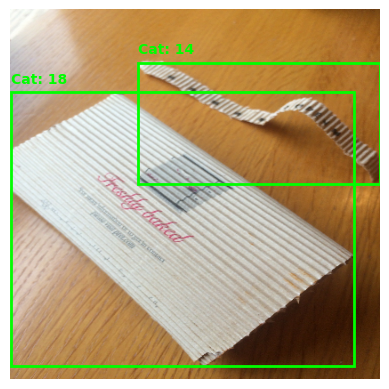

   category           x          y           w           h
0        18    0.270657  92.782821  386.769031  308.396291
1        14  143.718933  59.283553  272.281067  136.433382


In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Input data
data = {'image_data': {'link': 'https://farm66.staticflickr.com/65535/47803331152_ee00755a2e_o.png', 'height': 2049, 'width': 1537}, 'bboxes': [{'category': 18, 'x': 1.0, 'y': 457.0, 'w': 1429.0, 'h': 1519.0}, {'category': 14, 'x': 531.0, 'y': 292.0, 'w': 1006.0, 'h': 672.0}]}

# Target size
TARGET_SIZE = 416

# Load image from URL using tensorflow
image_path = './images/official/47803331152_ee00755a2e_o.png'
image_data = tf.io.read_file(image_path)
image = tf.image.decode_png(image_data, channels=3)

# Original size
orig_height = data['image_data']['height']
orig_width = data['image_data']['width']

# Resize image to 416x416
image_resized = tf.image.resize(image, [TARGET_SIZE, TARGET_SIZE])
image_resized = tf.cast(image_resized, tf.uint8).numpy()

# Load bounding box info into pandas
bboxes_df = pd.DataFrame(data['bboxes'])

# Calculate scale factors
scale_x = TARGET_SIZE / orig_width
scale_y = TARGET_SIZE / orig_height

# Resize bounding boxes accordingly
bboxes_df['x'] = bboxes_df['x'] * scale_x
bboxes_df['y'] = bboxes_df['y'] * scale_y
bboxes_df['w'] = bboxes_df['w'] * scale_x
bboxes_df['h'] = bboxes_df['h'] * scale_y

# Plot the resized image with bounding box
fig, ax = plt.subplots(1)
ax.imshow(image_resized)

for idx, row in bboxes_df.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='lime', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y - 10, f"Cat: {int(row['category'])}", color='lime', fontsize=10, weight='bold')

plt.axis('off')
plt.show()
print(bboxes_df)

In [12]:
def best_anchor_index(box_wh, anchors):
    box_area = box_wh[0] * box_wh[1]
    anchor_areas = anchors[:, 0] * anchors[:, 1]
    inter = np.minimum(anchors[:, 0], box_wh[0]) * np.minimum(anchors[:, 1], box_wh[1])
    iou = inter / (box_area + anchor_areas - inter)
    return np.argmax(iou)

def parser_flat(link, height, width, category, x, y, w, h):
    # Convert tensors to numpy
    link = link.numpy().decode("utf-8")
    height = height.numpy()
    width = width.numpy()

    x = x.numpy()
    y = y.numpy()
    w = w.numpy()
    h = h.numpy()
    category = category.numpy()

    image_path = './images/official/{}'.format(extract_id_from_url_with_Extension(link))

    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [TARGET_SIZE, TARGET_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    scale_x = TARGET_SIZE / width
    scale_y = TARGET_SIZE / height

    label_13 = []
    label_26 = []
    for i in range(len(category)):
        formated = (5 + NUM_CLASSES) * [0]
        formated[0] = x[i] * scale_x + (w[i] * scale_x) / 2  # center_x
        formated[1] = y[i] * scale_y + (h[i] * scale_y) / 2  # center_y
        formated[2] = w[i] * scale_x
        formated[3] = h[i] * scale_y
        formated[4] = 1.0
        formated[5 + category[i]] = 1

        best_idx = best_anchor_index([formated[2], formated[3]], ANCHORS)
        #print(best_idx,extract_id_from_url_with_Extension(link))
        for scale, mask in ANCHOR_INDECES.items():
            if best_idx in mask:
                if scale == 13:
                    label_13.append(formated)
                    #print(scale,extract_id_from_url_with_Extension(link))
                else:
                    label_26.append(formated)
                    #print(scale,extract_id_from_url_with_Extension(link))
                break


    max_length = max(len(label_13),len(label_26))
    while len(label_13) != max_length:
        label_13.append((5 + NUM_CLASSES) * [0])
    while len(label_26) != max_length:
        label_26.append((5 + NUM_CLASSES) * [0])

    label_13 = tf.convert_to_tensor(label_13, dtype=tf.float32)
    label_26 = tf.convert_to_tensor(label_26, dtype=tf.float32)

    return image, (label_13,label_26)

def parser_wrapper(link, height, width, category, x, y, w, h):
    image, label = tf.py_function(
        func=parser_flat,
        inp=[link, height, width, category, x, y, w, h],
        Tout=(tf.float32, tf.float32)
    )
    image.set_shape([TARGET_SIZE, TARGET_SIZE, 3])
    label.set_shape([2,None, 5 + NUM_CLASSES])
    return image, label

print(len(official_data_formated))

def generator():
    
    for official_data in official_data_formated:
        yield (
            official_data['image_data']['link'],
            official_data['image_data']['height'],
            official_data['image_data']['width'],
            [box['category'] for box in official_data['bboxes']],
            [box['x'] for box in official_data['bboxes']],
            [box['y'] for box in official_data['bboxes']],
            [box['w'] for box in official_data['bboxes']],
            [box['h'] for box in official_data['bboxes']]
        )

# Define output signature correctly
output_signature = (
    tf.TensorSpec(shape=(), dtype=tf.string),  # link
    tf.TensorSpec(shape=(), dtype=tf.int32),  # height
    tf.TensorSpec(shape=(), dtype=tf.int32),  # width
    tf.TensorSpec(shape=(None,), dtype=tf.int32),  # categories
    tf.TensorSpec(shape=(None,), dtype=tf.float32),  # x
    tf.TensorSpec(shape=(None,), dtype=tf.float32),  # y
    tf.TensorSpec(shape=(None,), dtype=tf.float32),  # w
    tf.TensorSpec(shape=(None,), dtype=tf.float32),  # h
)

dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
dataset = dataset.shuffle(1000)
dataset = dataset.repeat()
dataset = dataset.map(parser_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.padded_batch(
    1,
    padded_shapes=(
        [TARGET_SIZE, TARGET_SIZE, 3],               # image shape
        [2,None, 5 + NUM_CLASSES]      # label shape with variable number of boxes
    ),
    padding_values=(
        0.0,   # image padding (float32)
        0.0    # label padding (float32)
    )
).prefetch(tf.data.AUTOTUNE)


1500


/home/no0byeby/projects/trashDetecttion/myenv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Image shape: (416, 416, 3)
Image shape: tf.Tensor(
[[ 88.51928  325.0592    92.173744 152.1093     1.         0.
    0.         0.         0.         0.         1.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.      ]
 [264.23816  282.8367    36.34163  120.71307    1.         0.
    0.         0.         0.         0.         1.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.      

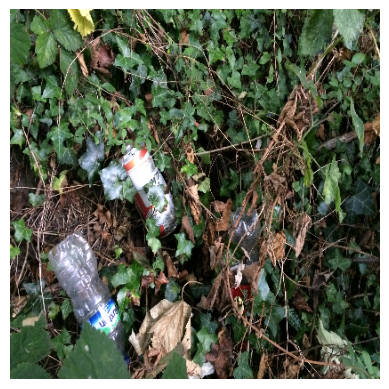

In [29]:

fig, ax = plt.subplots(1)
ind = 3
for image_batch, label_batch in dataset.take(1):
    ax.imshow(image_batch[ind])
    print("Image shape:", image_batch[ind].shape)
    print("Image shape:", label_batch[ind][0])
    print("Image shape:", label_batch[ind][1])
    print("Image shape:", label_batch[ind].shape)

plt.axis('off')
plt.show()

In [ ]:
def iou(box, clusters):
    # box: [w, h]
    # clusters: [[w1, h1], [w2, h2], ...]
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]
    iou_ = intersection / (box_area + cluster_area - intersection)
    return iou_

def kmeans(boxes, k, dist=np.median, seed=42):
    np.random.seed(seed)
    # Initialize clusters randomly
    clusters = boxes[np.random.choice(boxes.shape[0], k, replace=False)]
    while True:
        distances = []
        for box in boxes:
            distances.append(1 - iou(box, clusters))
        distances = np.array(distances)  # shape (num_boxes, k)
        nearest_clusters = np.argmin(distances, axis=1)
        new_clusters = []
        for cluster_idx in range(k):
            cluster_boxes = boxes[nearest_clusters == cluster_idx]
            if len(cluster_boxes) == 0:
                # Avoid empty clusters by reinitializing randomly
                new_clusters.append(clusters[cluster_idx])
            else:
                new_clusters.append(dist(cluster_boxes, axis=0))
        new_clusters = np.array(new_clusters)
        if np.all(clusters == new_clusters):
            break
        clusters = new_clusters
    return clusters

# Example usage

#[[bboxes[2],bboxes[3]] for image_batch, label_batch in dataset for bboxes in label_batch if bboxes[4] == 1]
boxes = np.array([
    [bbox[2].numpy(), bbox[3].numpy()]
    for image_batch, label_batch in dataset
    for label in label_batch
    for bbox in label
    if bbox[4].numpy() == 1
])
    
print(len(boxes))

anchors = kmeans(boxes, k=6)
print("Anchors:", anchors)
print(np.mean([boxess[0] for boxess in boxes]),np.mean([boxess[1] for boxess in boxes]))

2025-07-16 11:22:04.920002: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


4784
Anchors: [[ 72.22222    58.950325 ]
 [ 17.561403   14.1470585]
 [ 35.25196    29.227486 ]
 [166.44061   143.75555  ]
 [  9.894817    7.009804 ]
 [  4.75817     3.8235295]]
49.607246 42.14517


In [ ]:
with tf.GradientTape() as tape:
    image_batch,label_batch = dataset.take(1)
    print(batch)
    y_pred = model(image_batch, training=True)
    #print(np.array(y_pred).shape)
    loss_value = yolo_multihead_loss(label_batch, y_pred)
    tf.print("Loss:", loss_value)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, None, 65), dtype=tf.float32, name=None))>


NameError: name 'image_batch' is not defined

In [24]:
model.fit(dataset, epochs=30)

Epoch 1/30
     43/Unknown 2457s 56s/step - loss: 46.4627

KeyboardInterrupt: 